In [4]:
df = df.drop(['event_name', 'tweet_id', 'image_id', 'tweet_text', 'label', 'label_text', 'label_text_image'], axis=1)

# display the updated DataFrame
print(df.head())

                                               image  \
0  data_image/california_wildfires/10_10_2017/917...   
1  data_image/california_wildfires/10_10_2017/917...   
2  data_image/california_wildfires/10_10_2017/917...   
3  data_image/california_wildfires/10_10_2017/917...   
4  data_image/california_wildfires/10_10_2017/917...   

                         label_image  
0  infrastructure_and_utility_damage  
1  infrastructure_and_utility_damage  
2  infrastructure_and_utility_damage  
3  infrastructure_and_utility_damage  
4         other_relevant_information  


In [5]:
# define the string to concatenate
prefix = 'C:/Users/kaust/Downloads/'

# apply the lambda function to concatenate the prefix with every entry in the 'Name' column
df['image'] = df['image'].apply(lambda x: prefix + x)

# display the updated DataFrame
print(df)

                                                 image  \
0    C:/Users/kaust/Downloads/data_image/california...   
1    C:/Users/kaust/Downloads/data_image/california...   
2    C:/Users/kaust/Downloads/data_image/california...   
3    C:/Users/kaust/Downloads/data_image/california...   
4    C:/Users/kaust/Downloads/data_image/california...   
..                                                 ...   
950  C:/Users/kaust/Downloads/data_image/iraq_iran_...   
951  C:/Users/kaust/Downloads/data_image/california...   
952  C:/Users/kaust/Downloads/data_image/mexico_ear...   
953  C:/Users/kaust/Downloads/data_image/california...   
954  C:/Users/kaust/Downloads/data_image/hurricane_...   

                                label_image  
0         infrastructure_and_utility_damage  
1         infrastructure_and_utility_damage  
2         infrastructure_and_utility_damage  
3         infrastructure_and_utility_damage  
4                other_relevant_information  
..                         

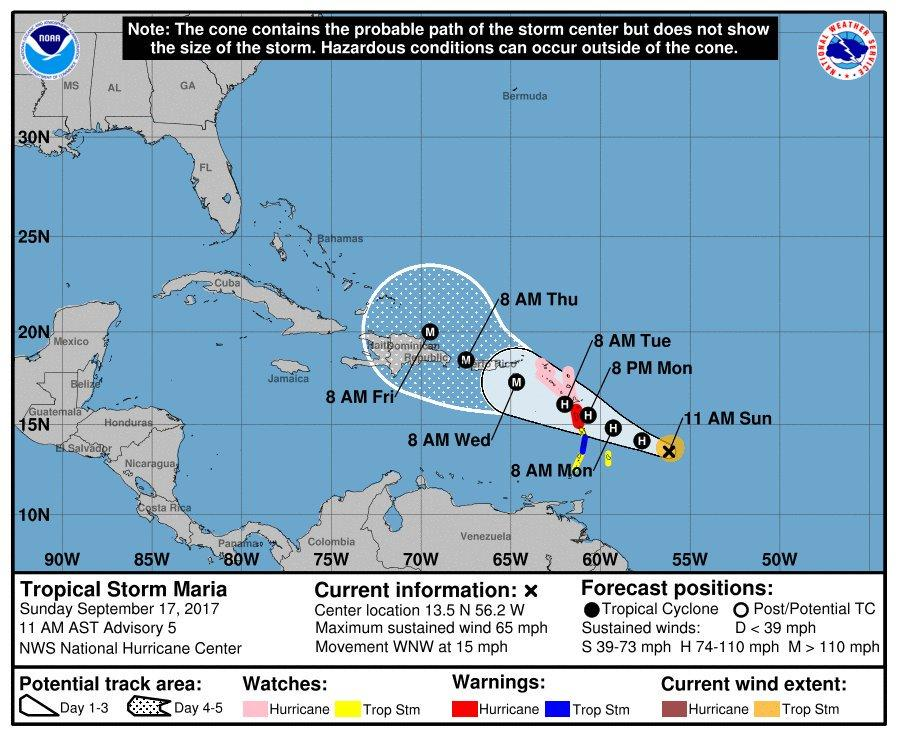

In [6]:
from IPython.display import Image

# specify the file path of your image with forward slashes
file_path = df.loc[2433, 'image']

# display the image
Image(filename=file_path)

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [8]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define the image data generator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Define the batch size and image size for the generator
batch_size = 32
image_size = (224, 224)

In [20]:
from keras.utils import to_categorical
# Define a dictionary to map each label to a number
label_map = {
    'affected_individuals': 0,
    'infrastructure_and_utility_damage': 1,
    'injured_or_dead_people': 2,
    'missing_or_found_people': 3,
    'rescue_volunteering_or_donation_effort': 4,
    'vehicle_damage': 5,
    'other_relevant_information': 6,
    'not_humanitarian': 7,
}

# Replace each label with a number
train_df['label_image'] = train_df['label_image'].replace(label_map)
test_df['label_image'] = test_df['label_image'].replace(label_map)


train_labels = to_categorical(train_df['label_image'])
test_labels = to_categorical(test_df['label_image'])

# Create the image data generators for the training and testing sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='label_image',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw')
    
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='label_image',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw')

Found 5664 validated image filenames.
Found 1417 validated image filenames.


In [21]:
# Load the ResNet50 model with pre-trained weights and without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [22]:
import tensorflow as tf
# Add a new top layer for classification
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(2, activation='softmax')(x)


In [23]:
# Create the final model with the ResNet50 base and the new top layer
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [24]:
# Freeze the weights of the base model for transfer learning
for layer in base_model.layers:
    layer.trainable = False

In [33]:
# Compile the model with the categorical crossentropy loss and Adam optimizer
model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

Epoch 1/10
 24/177 [===>..........................] - ETA: 6:55 - loss: 5.1771 - accuracy: 0.0286

C:\Users\kaust\anaconda3\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 72/177 [===========>..................] - ETA: 5:35 - loss: 5.2140 - accuracy: 0.0299

KeyboardInterrupt: 